# Escaping particles

Sometimes we are not interested in particles that get too far from the central body.  Here we will define a radius beyond which we remove particles from the simulation.  Let's set up an artificial situation with 2 planets, and the inner one simply moves radially outward with $v > v_{escape}$.

In [1]:
import rebound
import numpy as np
def setupSimulation():
    rebound.reset()
    rebound.integrator = "ias15" # IAS15 is the default integrator, so we don't need this line
    rebound.add(m=1.)
    rebound.add(m=1e-3,x=1.,vx=2.)
    rebound.add(m=1e-3,a=1.25,anom=np.pi/2)
    rebound.move_to_com()

Each particle has an ID, assigned to it in the order they were added to the simulation:

In [2]:
setupSimulation()
print([rebound.particles[i].ID for i in range(rebound.N)])

[0, 1, 2]


Now let's run a simulation for 20 years (in default units where $G=1$ of AU, yr/2$\pi$, and $M_\odot$, see [Units.ipynb](Units.ipynb) for how to change units), and set up a 50 AU sphere beyond which we remove particles from the simulation.  We can do this by passing a `maxR` value to `rebound.integrate`.  If a particle's distance (from the origin of whatever inertial reference frame chosen) exceeds `maxR`, the particle is removed from the simulation.  It's probably therefore important to have moved to the center of momentum frame in `setupSimulation()` so that our system doesn't slowly drift out of our sphere:

In [3]:
rebound.integrate(20.*2.*np.pi, maxR=50.)

ParticleEscaping: At least one particle's distance > maxR.

If we just run things directly, the program crashes with an exception.  But we can instead deal with the exception in a customized way. Let's try removing escaping particles from the simulation with `rebound.remove_particle`:

In [4]:
setupSimulation() # Resets everything
Noutputs = 1000
times = np.linspace(0,20.*2.*np.pi,Noutputs)
xs = np.zeros((3,Noutputs))
ys = np.zeros((3,Noutputs))
for i,time in enumerate(times):
    try:
        rebound.integrate(time,maxR=50.)    
        for j in range(rebound.N):
            xs[j,i] = rebound.particles[j].x
            ys[j,i] = rebound.particles[j].y
    except rebound.ParticleEscaping as e:
        rebound.remove_particle(e.id1)
        print("Particle {0} went beyond maxR at t={1}".format(e.id1, rebound.t))

Particle 1 went beyond maxR at t=33.52651791650018


Let's check that the particle 1 was correctly removed from the simulation:

In [5]:
print("Number of particles remaining = {0}".format(rebound.N))
print("ID of rebound.particles[1] = {0}".format(rebound.particles[1].ID))

Number of particles remaining = 2
ID of rebound.particles[1] = 2


So this worked as expected.  We went down to 2 particles, and `particles[1]` (which had `ID = 1` before) has evidently been replaced with `particles[2]`).  `rebound.remove_particles` removes the particle from the `particles` array corresponding to the index that you pass it, and shifts all particles with higher indices down by one (so IDs will always be sorted in ascending order).  See [IDs.ipynb](IDs.ipynb) for more info.  Now let's plot what we got:

(-2, 10)

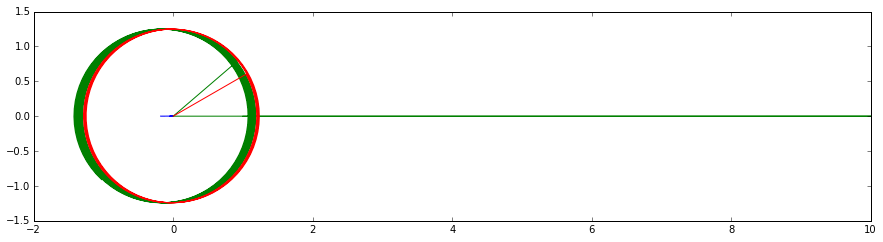

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(15,5))
for i in range(3):
    ax.plot(xs[i,:], ys[i,:])
ax.set_aspect('equal')
ax.set_xlim([-2,10])

Uh oh.  There are a couple issues contributing to these strange results.  First, we kept updating `xs[1]` with `particles[1].x` after `particle[1]` was removed.  This means that following the removal, `xs[1]` all of a sudden started getting populated by the values for the particle with `ID=2`.  This is why the radial green orbit (horizontal line along the $x$ axis) all of a sudden turns into the roughly circular orbit corresponding to the outer particle with `ID=2` (originally red).  

The second problem is that when we get the exception, we aren't storing the `x` and `y` values for that timestep, so they remain initialized at 0.  This is why all the colors jump to the origin at some point (because `plot` is connecting all the points with lines).  One way to fix these problems is:

Particle 1 went beyond maxR at t=33.52651791650018


(-2, 10)

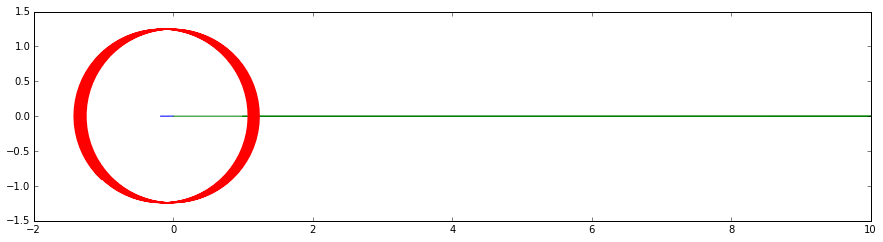

In [10]:
setupSimulation() # Resets everything
Noutputs = 1000
times = np.linspace(0,20.*2.*np.pi,Noutputs)
xs = np.zeros((3,Noutputs))
ys = np.zeros((3,Noutputs))
for i,time in enumerate(times):
    try:
        rebound.integrate(time,maxR=50.)    
        for j in range(rebound.N):
            xs[rebound.particles[j].ID,i] = rebound.particles[j].x
            ys[rebound.particles[j].ID,i] = rebound.particles[j].y
    except rebound.ParticleEscaping as e:
        print("Particle {0} went beyond maxR at t={1}".format(e.id1, rebound.t)) 
        rebound.remove_particle(e.id1)
        for j in range(rebound.N):
            xs[rebound.particles[j].ID,i] = rebound.particles[j].x
            ys[rebound.particles[j].ID,i] = rebound.particles[j].y
fig,ax = plt.subplots(figsize=(15,5))
for i in range(3):
    ax.plot(xs[i,:], ys[i,:])
ax.set_aspect('equal')
ax.set_xlim([-2,10])

Much better!  Since at the beginning of the integration the IDs match up with the corresponding indices in the `xs` and `ys` arrays, we solved the first problem by using the IDs as indices throughout the simulation.
For the second problem, we simply had to populate the `xs` and `ys` array when we handled the exception.

As an aside, the horizontal drift of the circular orbit is a real effect:  in the center of mass frame, if the Jupiter-mass planet is drifting right at some speed, the Sun must be moving at a speed lower by a factor of approximately 1000 (their mass ratio) in the opposite direction, so the Sun-particle2 system slowly drifts left.  If we integrated long enough, this would mean all our particles would eventually leave our box.  

If we wanted to make sure things stayed in the box, we could additionally move to new center of mass frame after each removal of a particle, but this would introduce unphysical jumps in the remaining particles' time series, since their coordinates are measured between different inertial frames.  Of course whether this matters depends on the application!